In [4]:
from pathlib import Path
import nmrespy as ne

root = Path("../../..")
data_dir = root / "data" / "estradiol" / "1"
output_dir = root / "code" / "reviewer-1" / "estradiol-noise-tolerance" / "output"
output_dir.mkdir(exist_ok=True, parents=True)

In [5]:
estimator_dir = output_dir / "estimators"
estimator_dir.mkdir(exist_ok=True, parents=True)
estimator_base_path = estimator_dir / "estimator_base.pkl"

if estimator_base_path.is_file():
    estimator_base = ne.Estimator2DJ.from_pickle(estimator_base_path)
else:
    estimator_base = ne.Estimator2DJ.new_bruker(data_dir)
    estimator_base.phase_data(p0=4.563, p1=-6.239)
    estimator_base.to_pickle(estimator_base_path)

In [6]:
import numpy as np

N1, N2 = estimator_base._data.shape
first_fid = estimator_base._data[0]

def add_noise(data: np.ndarray, snr: int) -> None:
    _, data_n2 = data.shape
    for n1 in range(data.shape[0]):
        noise = ne.sig.make_noise(first_fid, float(snr))
        data[n1] += noise[:data_n2]

In [7]:
from copy import deepcopy
import numpy as np

np.random.seed(0)

snrs = [45, 40, 35, 30]
estimator_path_tmpl = str(estimator_dir / "estimator_{}db.pkl")
all_paths = [Path(estimator_path_tmpl.format(snr)) for snr in snrs]
estimators = {}

if all([path.is_file() for path in all_paths]):
    for snr, path in zip(snrs, all_paths):
        estimator = ne.Estimator2DJ.from_pickle(path)
        estimators[snr] = dict(path=path, obj=estimator)
else: 
    for snr in snrs:
        estimator_noisy = deepcopy(estimator_base)
        estimator_path = Path(estimator_path_tmpl.format(snr))
        add_noise(estimator_noisy._data, snr)
        estimators[snr] = dict(path=estimator_path, obj=estimator_noisy)
        estimator_noisy.to_pickle(estimator_path, force_overwrite=True)

In [8]:
def process_1d(data: np.ndarray, lb: float | None = None, p0_p1: tuple[float, float] | None = None):
    if lb is not None:
        data = ne.sig.exp_apodisation(data, lb)
    data = ne.sig.zf(data)
    data[0] *= 0.5
    data = ne.sig.ft(data)
    if p0_p1 is not None:
        p0, p1 = p0_p1
        data = ne.sig.phase(data, p0=[p0], p1=[p1])
    return data.real

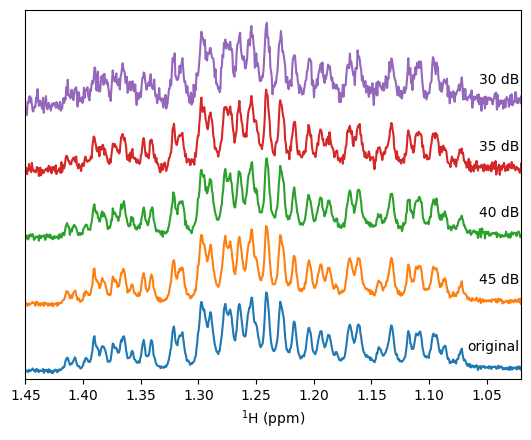

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
base_spectrum = process_1d(deepcopy(first_fid))
_, shifts = estimator_base.get_shifts(unit="ppm", meshgrid=False, pts=(1, base_spectrum.size))
ax.set_xlim(1.45, 1.02)
ax.set_ylim(-5e3, 1.5e5)
ax.set_yticks([])
ax.set_xlabel("$^{1}$H (ppm)")
ax.plot(shifts, base_spectrum)

text_x = 1.022
text_yshift = 7.0e3
ax.text(text_x, text_yshift, "original", ha="right")

spectrum_yshift = 2.8e4
for i, (snr, dct) in enumerate(estimators.items(), start=1):
    estimator = dct["obj"] 
    fid = deepcopy(estimator._data[0])
    spectrum = process_1d(fid) + (i * spectrum_yshift)
    ax.plot(shifts, spectrum)
    ax.text(1.022, text_yshift + i * spectrum_yshift, "{} dB".format(snr), ha="right")

In [24]:
estimation_kwargs = dict(
    region=(1.45, 1.02),
    noise_region=(8.1, 7.9),
    region_unit="ppm",
    initial_guess=90,
    max_iterations=1000,
    check_neg_amps_every=100,
)

In [9]:
np.random.seed(0)

rerun = False
for snr, dct in estimators.items():
    estimator = dct["obj"]
    path = dct["path"]
    try:
        if rerun:
            estimator._results = []
        estimator.get_results()
    except ValueError:
        print(ne._misc.boxed_text("ESTIMATING {} dB DATASET".format(snr)))
        estimator.estimate(**estimation_kwargs)
        estimator.to_pickle(path, force_overwrite=True)

┌────────────────────────┐
│ESTIMATING 45 dB DATASET│
└────────────────────────┘
┌───────────────────────────────────────┐
│ESTIMATING REGION: 1.45 - 1.02 ppm (F2)│
└───────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators has been pre-defined
	Number of oscillators: 90
--> Pencil parameters: 64, 128
--> Enhanced Block Hankel matrix constructed:
	Size: 8192 x 8385
	Memory: 1.0236GiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	factors detected. These have been deleted.
	Corrected number of oscillations: 88
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 31 secs, 116 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad.

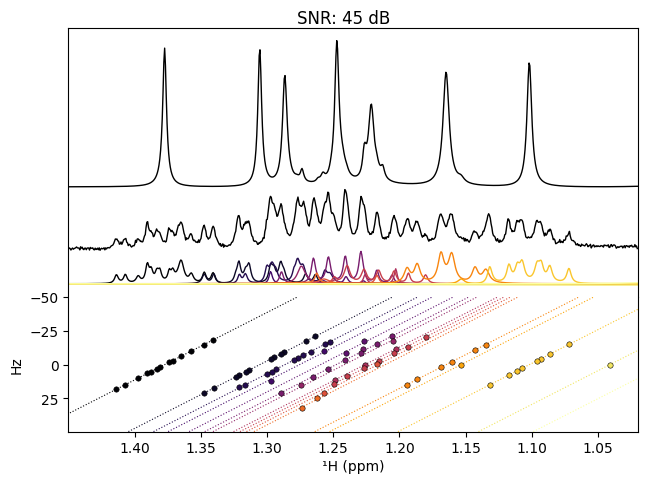

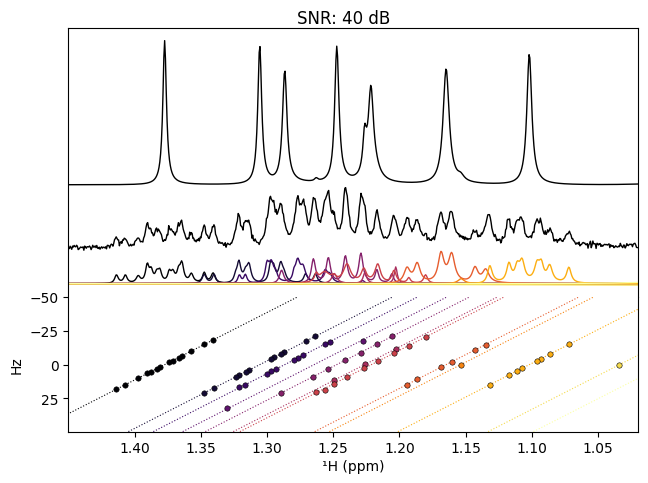

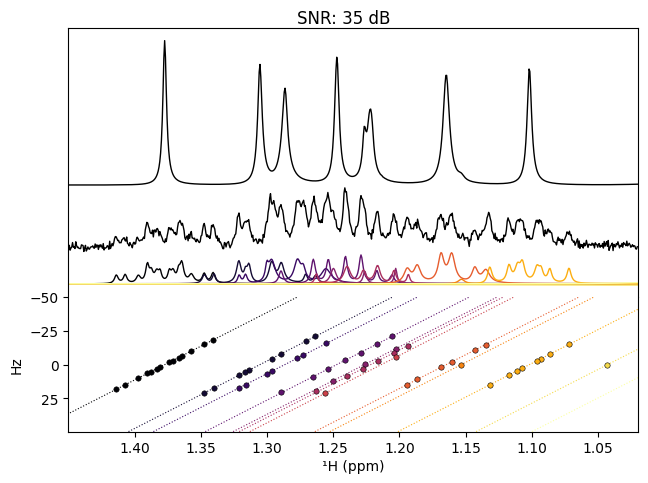

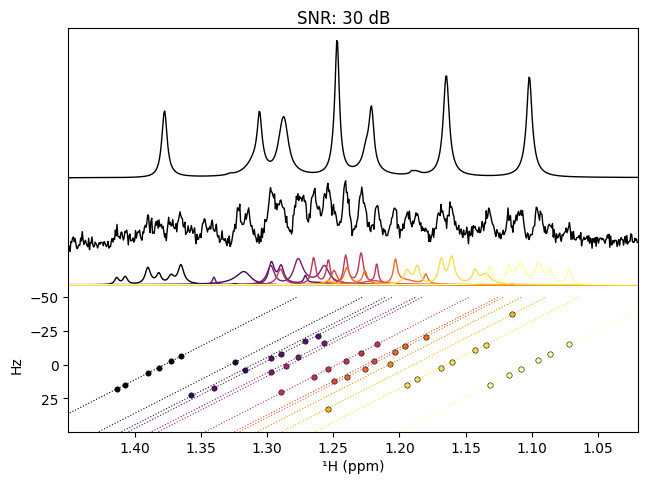

In [11]:
thold = 1.991
plot_kwargs = dict(
    contour_base=1.0e6, 
    contour_factor=2.0, 
    contour_nlevels=1, 
    marker_size=15.0,
    multiplet_show_center_freq=False,
    region_unit="ppm",
    axes_top=0.94,
    axes_bottom=0.1,
    multiplet_thold=thold,
    multiplet_colors="inferno",
)

for snr, einfo in estimators.items():
    estimator = deepcopy(einfo["obj"])
    estimator.predict_multiplets(thold=thold, rm_spurious=True)
    fig, axs = estimator.plot_result(**plot_kwargs)
    fig.suptitle("SNR: {} dB".format(snr))

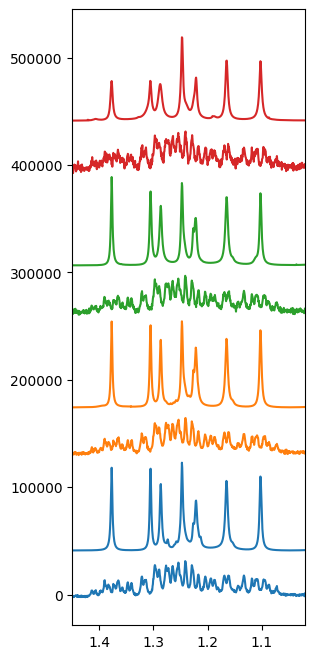

In [39]:
fig, ax = plt.subplots(figsize=(3.0, 8.0))
left, right = estimation_kwargs["region"]
ax.set_xlim(left, right)
yshift = 0.0
ydelta = 1.0e4
left_idx = np.searchsorted(-shifts, -left, side='right')
right_idx = np.searchsorted(-shifts, -right, side='left')
shifts_slice = shifts[left_idx : right_idx + 1]
for snr, einfo in estimators.items():
    estimator = einfo["obj"]
    spectrum_1d = process_1d(deepcopy(estimator._data[0]))[left_idx : right_idx + 1]
    spectrum_cupid = process_1d(estimator.cupid_signal())[left_idx : right_idx + 1]
    line, = ax.plot(shifts_slice, spectrum_1d + yshift)
    color = line.get_color()
    yshift = np.amax(line.get_ydata()) + ydelta
    line, = ax.plot(shifts_slice, spectrum_cupid + yshift, color=color)
    yshift = np.amax(line.get_ydata()) + ydelta

In [54]:
def get_top_7_integrals(estimator):
    idxs = []
    for f, idx in estimator.predict_multiplets(thold=thold).items():
        idxs.append((f / estimator.sfo[1], idx))
    idxs = sorted(sorted(idxs, key=lambda x: len(x[1]))[-7:], key=lambda x: -x[0]) 
    params = estimator.get_params()
    integrals = []
    for f_ppm, idx in idxs:
        integrals.append((f_ppm, params[idx, 0].sum()))
    return integrals

In [56]:
for snr, einfo in estimators.items():
    estimator = einfo["obj"]
    integrals = get_top_7_integrals(estimator)
    print("SNR {} dB:".format(snr))
    for f_ppm, integral in integrals:
        print("{:.3f} ppm : {:.1f}".format(f_ppm, integral))
    print()

SNR 45 dB:
1.377 ppm : 86.2
1.306 ppm : 83.4
1.287 ppm : 82.0
1.248 ppm : 92.1
1.221 ppm : 60.9
1.165 ppm : 111.1
1.102 ppm : 93.8

SNR 40 dB:
1.377 ppm : 81.3
1.306 ppm : 84.1
1.287 ppm : 78.8
1.247 ppm : 90.5
1.221 ppm : 88.2
1.165 ppm : 110.5
1.102 ppm : 101.2

SNR 35 dB:
1.377 ppm : 86.4
1.305 ppm : 88.0
1.287 ppm : 94.6
1.247 ppm : 88.5
1.222 ppm : 60.2
1.165 ppm : 114.5
1.102 ppm : 86.6

SNR 30 dB:
1.377 ppm : 55.2
1.305 ppm : 49.4
1.288 ppm : 84.4
1.247 ppm : 99.0
1.222 ppm : 58.3
1.165 ppm : 96.1
1.102 ppm : 95.5



In [53]:
for f, idx in idxs:
    amplitude = params[idx, 0].sum()
    print("{} ppm : {}".format(f, amplitude))

1.377334425321154 ppm : 86.19691468313238
1.3055110881121943 ppm : 83.40238677721884
1.2865471500086862 ppm : 82.02214648832404
1.2478791858565612 ppm : 92.12949412791494
1.2212723338973672 ppm : 60.86933343347979
1.1648099220594688 ppm : 111.07534448747121
1.1019910998528613 ppm : 93.75998454087616


## Considering Noisy PSYCHE Signals

In [65]:
def process_psyche(ser: np.ndarray, sw1: float, sw2: float) -> np.ndarray:
    drop_pts = 4
    chunk_pts = int(sw2 // sw1)
    fid = ser[:, drop_pts : drop_pts + chunk_pts].flatten()
    return fid

In [66]:
from bruker_utils import BrukerDataset

psyche_dir = root / "data" / "estradiol" / "2"
psyche_estimator_dir = output_dir / "psyche_estimators"
psyche_estimator_dir.mkdir(parents=True, exist_ok=True)

psyche_estimator_path_tmpl = str(psyche_estimator_dir / "estimator_{}dB.pkl")
all_psyche_paths = [Path(psyche_estimator_path_tmpl.format(snr)) for snr in snrs]

if all([path.is_file() for path in all_psyche_paths]):
    psyche_estimators = {}
    for snr, path in zip(snrs, all_psyche_paths):
        estimator = ne.Estimator1D.from_pickle(path)
        psyche_estimators[snr] = estimator
else:
    psyche_ds = BrukerDataset(psyche_dir)
    ser = psyche_ds.data
    params = psyche_ds.get_parameters()
    sw1 = float(params["acqu2s"]["SW_h"])
    sw2 = float(params["acqus"]["SW_h"])
    offset = float(params["acqus"]["O1"])
    sfo = float(params["acqus"]["SFO1"])
    grpdly = params["acqus"]["GRPDLY"]

    ser = ne.sig.convdta(ser, grpdly)

    psyche_fid_base = process_psyche(deepcopy(ser), sw1, sw2)
    expinfo_psyche = ne.ExpInfo(
        dim=1,
        sw=[sw2],
        offset=offset,
        sfo=sfo,
        nuclei=["1H"],
        default_pts=psyche_fid_base.shape,
    )
    psyche_estimator_base = ne.Estimator1D(psyche_fid_base, deepcopy(expinfo_psyche))
    
    psyche_estimators = {}
    for snr in snrs:
        ser_noisy = deepcopy(ser)
        add_noise(ser_noisy, snr)
        psyche_fid = process_psyche(ser_noisy, sw1, sw2)
        path = Path(psyche_estimator_path_tmpl.format(snr))
        psyche_estimator = ne.Estimator1D(psyche_fid, deepcopy(expinfo_psyche))
        psyche_estimator.to_pickle(path)
        psyche_estimators[snr] = dict(path=path, obj=psyche_estimator)

Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_45dB.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_40dB.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_35dB.pkl.
Saved file ../../../code/reviewer-1/estradiol-noise-tolerance/output/psyche_estimators/estimator_30dB.pkl.


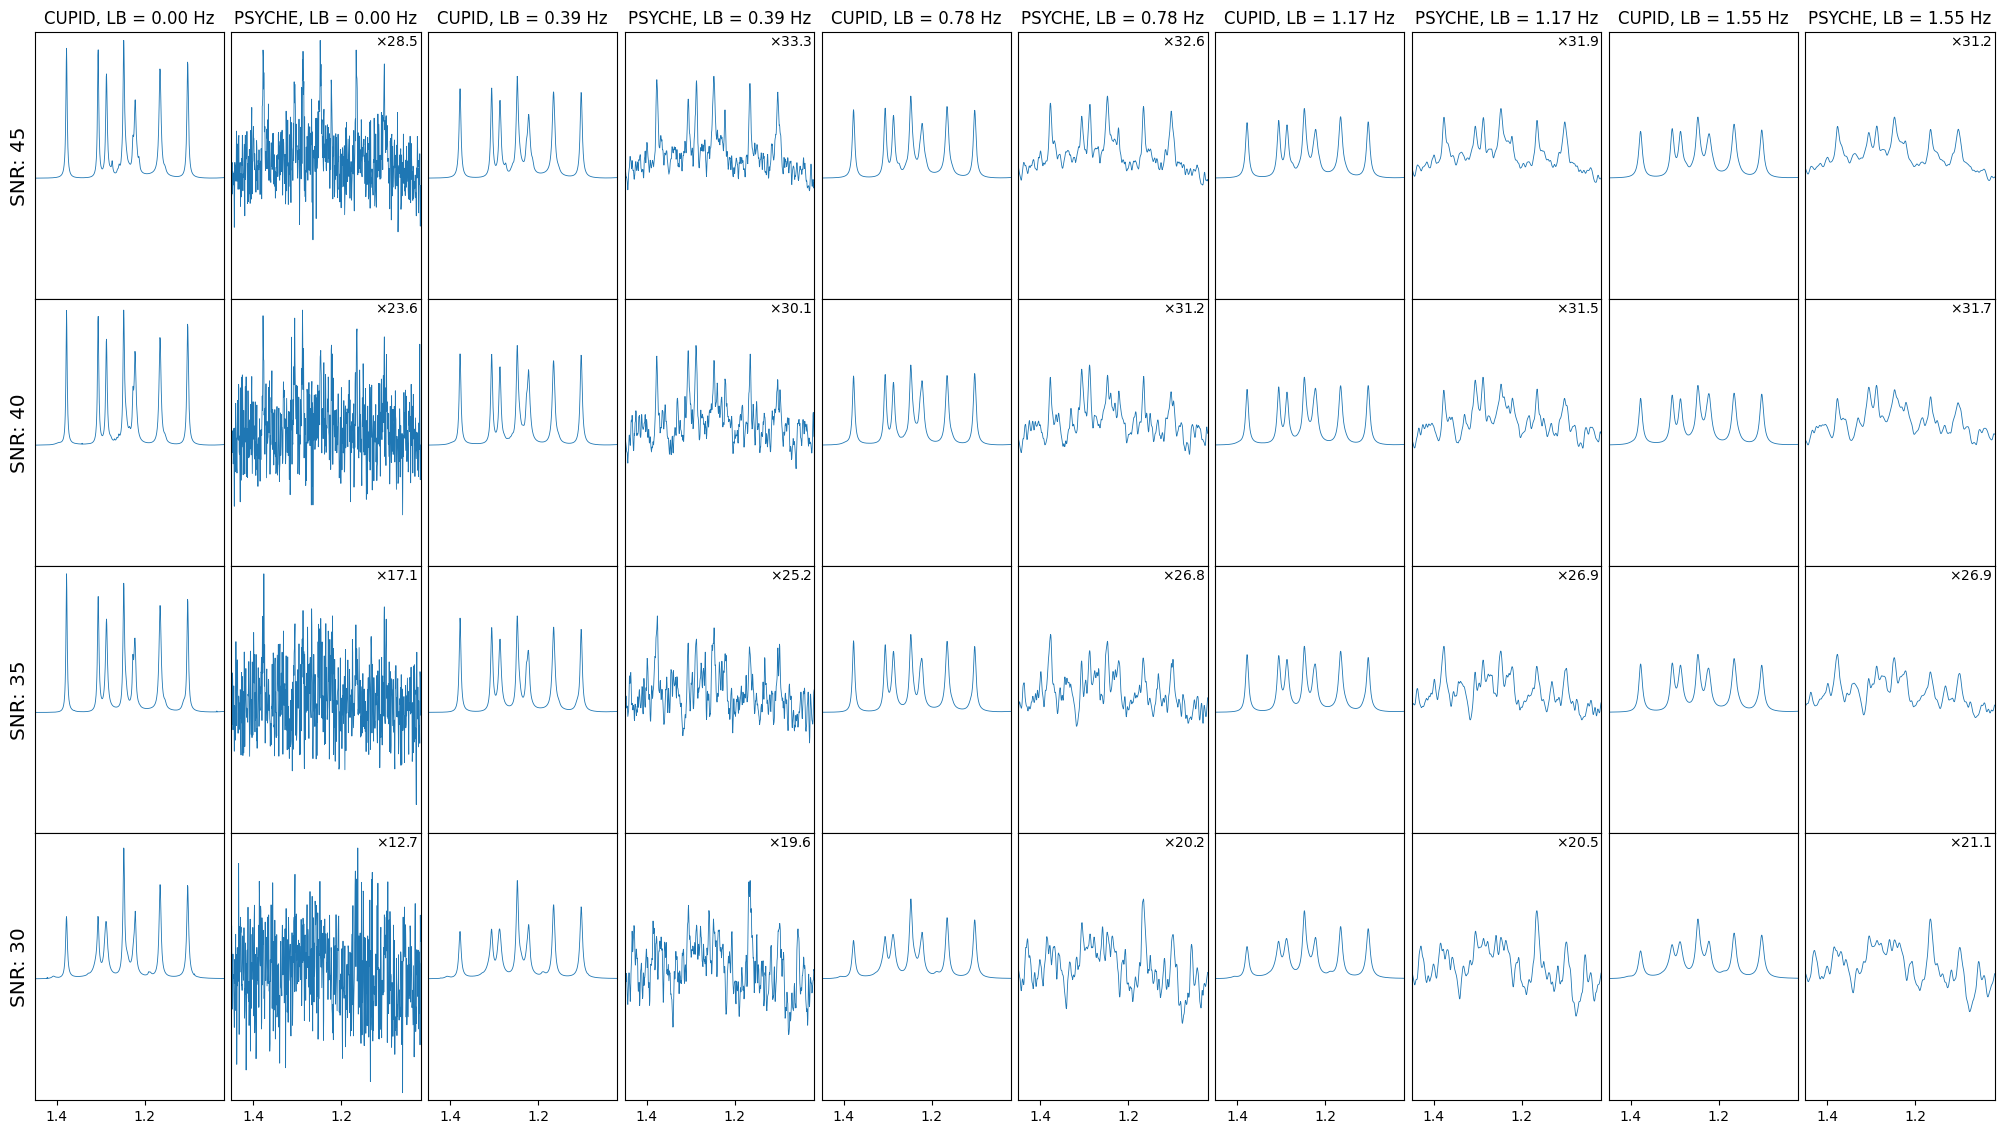

In [128]:
lbs = [0.0, 4.0, 8.0, 12.0, 16.0]
n_lbs = len(lbs)

fig, axs = plt.subplots(
    nrows=4,
    ncols=2 * n_lbs,
    figsize=(4.0 * n_lbs, 12.0),
    gridspec_kw=dict(
        left=0.01,
        right=0.99,
        top=0.95,
        bottom=0.06,
        wspace=0.04,
        hspace=0.0,
    )
)
plt.rcParams["lines.linewidth"] = 0.6

left, right = estimation_kwargs["region"]
xticks = [1.4, 1.3, 1.2, 1.1]
ylim = (-1.0e4, 1.0e5)
psyche_phase = (1.428, -5.942)
for ax_row in axs:
    for ax in ax_row:
        ax.set_xlim(left, right)
        ax.set_xticks(xticks)
        ax.set_ylim(ylim)

fig.text
        
left_idx = np.searchsorted(-shifts, -left, side='right')
right_idx = np.searchsorted(-shifts, -right, side='left')
shifts_slice = shifts[left_idx : right_idx + 1]
ymin, ymax = 0.0, 0.0
for ax_row, snr in enumerate(snrs):
    cupid_estimator = estimators[snr]["obj"]
    cupid_fid = cupid_estimator.cupid_signal()
    psyche_estimator = psyche_estimators[snr]["obj"]
    psyche_fid = deepcopy(psyche_estimator._data)
    for i, lb in enumerate(lbs):
        cupid_spectrum = process_1d(deepcopy(cupid_fid), lb=lb)[left_idx : right_idx + 1]
        psyche_spectrum = process_1d(deepcopy(psyche_fid), lb=lb, p0_p1=psyche_phase)[left_idx : right_idx + 1]
        cupid_max, cupid_min = np.max(cupid_spectrum), np.min(cupid_spectrum)
        psyche_max, psyche_min = np.max(psyche_spectrum), np.min(psyche_spectrum)
        scale = cupid_max / psyche_max
        psyche_spectrum *= scale
        if (mx := max(cupid_max, scale * psyche_max)) > ymax:
            ymax = mx
        if (mn := min(cupid_min, scale * psyche_min)) < ymin:
            ymin = mn
        cupid_ax = axs[ax_row, 2 * i]
        psyche_ax = axs[ax_row, 2 * i + 1]
        cupid_ax.plot(shifts_slice, cupid_spectrum)
        psyche_ax.plot(shifts_slice, psyche_spectrum)
        psyche_ax.text(0.99, 0.99, "$\\times {:.1f}$".format(scale), ha="right", va="top", transform=psyche_ax.transAxes)
        if ax_row == 0:
            lb_hz = (lb * cupid_estimator.sw()[1]) / (np.pi * (shifts.size - 1))
            cupid_ax.set_title("CUPID, LB = {:.2f} Hz".format(lb_hz))
            psyche_ax.set_title("PSYCHE, LB = {:.2f} Hz".format(lb_hz))
        if i == 0:
            cupid_ax.set_ylabel("SNR: {:.0f}".format(snr), fontsize="x-large")
        
ypad = 0.03 * (ymax - ymin)
for ax in axs.flatten():
    ax.set_ylim(ymin - ypad, ymax + ypad)
    ax.set_yticks([])